In [2]:
import evaluation.score_acculumator as score_accumulator
import evaluation.plotting_utils as plot_utils
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from tqdm import tqdm
import json, os, pathlib


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2" # change this to change gpu number

import torch
print(torch.cuda.get_device_name(torch.cuda.current_device()))

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package cmudict to
[nltk_data]     /home/cfoley_waller/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


NVIDIA GeForce RTX 3090


# Embedding similarity analysis

Run the following code segments to generate a similarity analysis of full-song embeddings. The embeddings require access to a gpu to run at a reasonable speed.

In [59]:
########### Download the model and read in the prediction data ########
embedding_model = SentenceTransformer('all-mpnet-base-v2')
model_outputs = [
    "data/model_outputs/llama-2-7b-test-outputs.json",
    "data/model_outputs/lyre-small-batch-checkpoint-50-test-outputs.json",
    "data/model_outputs/lyre-small-batch-checkpoint-100-test-outputs.json",
    "data/model_outputs/lyre-small-batch-checkpoint-150-test-outputs.json",
    "data/model_outputs/llama-2-7b-chat-test-outputs.json",
    "data/model_outputs/llama-2-7b-chat-temp-1-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-50-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-50-temp-1-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-100-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-100-temp-1-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-150-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-150-temp-1-test-outputs.json",
]
model_names = [
    "llama",
    "lyre_50",
    "lyre_100",
    "lyre_150",
    "llama_chat",
    "llama_chat_temp1",
    "lyre_chat_50",
    "lyre_chat_50_temp1",
    "lyre_chat_100",
    "lyre_chat_100_temp1",
    "lyre_chat_150",
    "lyre_chat_150_temp1",
]
colors = ['#fff5eb', '#fdb97d', '#e95d0d', '#7f2704'] + \
        ['#87CEFA', '#FFC0CB'] + \
        ['#6495ED','#FA8072']+ \
        ['#4169E1','#DC143C'] + \
        ["#191970", "#8B0000"] # gradient of orange colors for nonchat models followed by red & blue pairs indicating chat temp

ground_truth = pd.read_json(model_outputs[0], orient="records")['target_response'].to_list()
model_dbs = []
for i, path in enumerate(model_outputs):
    model_dbs.append(pd.read_json(path, orient="records")['model_response'].to_list())

In [66]:
def embed_songs(embedding_model, songlist, name=''):
    embedded = np.stack([embedding_model.encode(song) for song in tqdm(songlist, "Embedding "+name)])
    return embedded

def compute_similarity_and_l2(all_model_embeddings, target_embeddings, names, pca=0):
    norm = lambda x: x / np.linalg.norm(x)
    transform = lambda x: x
    if pca > 0:
        comp = PCA(n_components=pca)
        target_embeddings = comp.fit_transform(target_embeddings)
        transform = lambda x: comp.transform(x)

    similarity_scores = {n: 0 for n in names}
    l2_norms = {n: 0 for n in names}
    for i, embedding in enumerate(all_model_embeddings):
        emb = transform(embedding)
        scores = [np.dot(norm(emb[j]), norm(target_embeddings[j])) for j in tqdm(list(range(emb.shape[0])), "Scoring " +names[i])]
        l2_losses = [np.linalg.norm(emb[j] - target_embeddings[j])for j in tqdm(list(range(emb.shape[0])), "Scoring " +names[i])]
        similarity_scores[names[i]] = np.mean(scores)
        l2_norms[names[i]] = np.mean(l2_losses)
    return similarity_scores, l2_norms

In [61]:
target_embeddings = embed_songs(embedding_model, ground_truth, "target")
all_embeddings = [embed_songs(embedding_model, model_dbs[i], model_names[i]) for i in range(len(model_dbs))]

Embedding target:   0%|          | 0/117 [00:00<?, ?it/s]

Embedding lyre_chat_150_temp1: 100%|██████████| 117/117 [00:02<00:00, 42.76it/s]


In [67]:
similarity_scores, losses = compute_similarity_and_l2(all_embeddings, target_embeddings, model_names, pca=5)

Scoring lyre_chat_150_temp1: 100%|██████████| 117/117 [00:00<00:00, 62545.70it/s]


In [68]:
print(similarity_scores)
print(losses)

{'llama': 0.6226045, 'lyre_50': 0.5971462, 'lyre_100': 0.61839217, 'lyre_150': 0.64370954, 'llama_chat': 0.5600752, 'llama_chat_temp1': 0.58363664, 'lyre_chat_50': 0.59298384, 'lyre_chat_50_temp1': 0.67883027, 'lyre_chat_100': 0.61230665, 'lyre_chat_100_temp1': 0.6656607, 'lyre_chat_150': 0.7231926, 'lyre_chat_150_temp1': 0.68303025}
{'llama': 0.25582892, 'lyre_50': 0.2558355, 'lyre_100': 0.2450492, 'lyre_150': 0.23978873, 'llama_chat': 0.29568958, 'llama_chat_temp1': 0.29086557, 'lyre_chat_50': 0.24762127, 'lyre_chat_50_temp1': 0.22834022, 'lyre_chat_100': 0.25486976, 'lyre_chat_100_temp1': 0.23865642, 'lyre_chat_150': 0.22191991, 'lyre_chat_150_temp1': 0.23096102}


# PCA embeddings analysis
Using the SentenceBert embeddings, we can also analyze our model similarities in 3D space via PCA. Use the parameter `cp_offset` to sample different principal component windows, and highlight the differences between the finetuned and the Llama model outputs.

In [76]:
# Compute 10-component PCA
comp = PCA(n_components=10)
pc_offset = 3

# Transform embeddings
t1 = comp.fit_transform(target_embeddings)[:, pc_offset:pc_offset+3]
t_models = [comp.transform(emb)[:, pc_offset:pc_offset+3] for emb in all_embeddings]

centroids = plot_utils.plot_3d_centroids(
    [t_models[0], t_models[4], t_models[3], t_models[9], t1], # [t1] + t_models, 
    ["Llama-2-7b", "Llama-2-7b-chat", "Lyre", "Lyre-LM-Chat", 'Target'],#["target"] + model_names, 
    [colors[0], colors[4], colors[3], colors[9], 'darkseagreen'], # ['darkseagreen'] + colors
    range_limit=0.2
)

# Musical Structure Analysis
As per section 4.1 of our report, we can evaluate the musical & structural qualities of the finetuned Lyre model's predictions.
We analyze 8 different metrics. For more detail, refer to our report, or take a look at the code under [scoring_metrics.py](evaluation/scoring_metrics.py)

In [7]:
measures = ["diversity", "syllable", "meter", "semantics", "semantics_internal", "string_similarity", "tail_similarity", "head_similarity", "phonetics"]
tags = ["Lexical diversity (DI)", "Syllabic consistency (SY)", "Meter consistency (ME)", "Semantic consistency (SE)", "Internal semantic consistency (SI)", "Line similarity (SS)", "Line tail similarity (TS)", "Line head similarity (HS)", "Phonetic consistency (PH)"]


The following lines may take a while, especially if you don't have a powerful GPU. 

Consider **skipping to the next section**, and loading the saved results of the evaluation.

In [13]:
def build_score_accumulators(measures, model_outputs, names):
    accumulators = []
    for path in model_outputs:
        accum = score_accumulator.ScoreAccumulator(measures)
        with open(path, 'r') as f:
            db = json.load(f)
        accum.score_all_songs(db, num_workers=8)
        accumulators.append(accum)
    return accumulators

def find_common_keys_and_prune(databases):
    """
    Takes a list of databases, finds the set of common keys among all of them,
    and prunes any keys that are not shared among all the databases.

    :param dicts: List of dictionaries
    :return: List of dictionaries with only the common keys
    """
    
    if not databases:
        return []

    common_keys = set(databases[0].keys())
    for d in databases[1:]:
        common_keys.intersection_update(d.keys())
    
    # Prune keys that are not in the set of common keys
    pruned_dicts = [{k: d[k] for k in common_keys} for d in databases]

    return pruned_dicts

In [15]:
accumulators = build_score_accumulators(measures, model_outputs, model_names)
databases = [accum.get_database() for accum in accumulators]

 66%|██████▌   | 77/117 [05:00<03:01,  4.53s/it]

Error processing song: 9095848 Stanza keywords are too complex, please simplify


 73%|███████▎  | 85/117 [06:31<06:34, 12.34s/it]

Error processing song: 7864555 Stanza keywords are too complex, please simplify


100%|██████████| 117/117 [01:29<00:00,  1.31it/s]


You may notice that llama has rejected some of the prompts due to its value alignment. To generate a fair comparison, we will prune these from the lyre outputs.

In [16]:
pruned_dbs = find_common_keys_and_prune(databases)

# write databases to original file with "scores" suffix
for i, db in enumerate(pruned_dbs):
    out_name = os.path.splitext(model_outputs[i])[0] + "_scores"+ os.path.splitext(model_outputs[i])[1]
    print(out_name)
    with open(out_name, "w") as f:
        f.write(json.dumps(db, indent = 2, separators=[",",":"]))

data/model_outputs/llama-2-7b-test-outputs_scores.json
data/model_outputs/lyre-small-batch-checkpoint-50-test-outputs_scores.json
data/model_outputs/lyre-small-batch-checkpoint-100-test-outputs_scores.json
data/model_outputs/lyre-small-batch-checkpoint-150-test-outputs_scores.json
data/model_outputs/llama-2-7b-chat-test-outputs_scores.json
data/model_outputs/llama-2-7b-chat-temp-1-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-50-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-50-temp-1-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-100-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-100-temp-1-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-150-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-150-temp-1-test-outputs_scores.json


### Skip here if you don't want to wait for the metrics to run
You can load metrics from a previously run file.

In [4]:
pruned_dbs = []
for i, fname in enumerate(model_outputs):
    scores_name = os.path.join("data/metrics", os.path.basename(os.path.splitext(fname)[0] + "_scores"+ os.path.splitext(fname)[1]))
    print(scores_name)
    with open(scores_name, 'r') as f:
        pruned_dbs.append(json.load(f))

data/metrics/llama-2-7b-test-outputs_scores.json
data/metrics/lyre-small-batch-checkpoint-50-test-outputs_scores.json
data/metrics/lyre-small-batch-checkpoint-100-test-outputs_scores.json
data/metrics/lyre-small-batch-checkpoint-150-test-outputs_scores.json
data/metrics/llama-2-7b-chat-test-outputs_scores.json
data/metrics/llama-2-7b-chat-temp-1-test-outputs_scores.json
data/metrics/lyre-chat-small-batch-checkpoint-50-test-outputs_scores.json
data/metrics/lyre-chat-small-batch-checkpoint-50-temp-1-test-outputs_scores.json
data/metrics/lyre-chat-small-batch-checkpoint-100-test-outputs_scores.json
data/metrics/lyre-chat-small-batch-checkpoint-100-temp-1-test-outputs_scores.json
data/metrics/lyre-chat-small-batch-checkpoint-150-test-outputs_scores.json
data/metrics/lyre-chat-small-batch-checkpoint-150-temp-1-test-outputs_scores.json


In [5]:
def build_all_scores_db(databases, names, measures):
    names = names + ["target"]
    all_scores = {m:{n : [] for n in names} for m in measures}
    
    # extract scores
    gt_scores = [databases[0][id]["target_scores"] for id in databases[0].keys()]
    for i in range(len(databases)):
        databases[i] = [databases[i][id]["pred_scores"] for id in databases[i].keys()]
    databases.append(gt_scores)

    #build all scores database
    for m in measures:
        for i, n in enumerate(names):
            all_scores[m][n] = np.array([song[m] for song in databases[i]])
                
    return all_scores

In [8]:
all_scores = build_all_scores_db(pruned_dbs, model_names, measures)

# map between 0 and 100
measure_scales = []
for m in measures:
    for name in model_names + ["target"]:
        if m != 'diversity':
            all_scores[m][name] = 100 * np.exp(-all_scores[m][name])
        else:
            all_scores[m][name] = 100 * np.exp(all_scores[m][name])

print(f"Measures available: {'  -  '.join(list(all_scores.keys()))}")

Measures available: diversity  -  syllable  -  meter  -  semantics  -  semantics_internal  -  string_similarity  -  tail_similarity  -  head_similarity  -  phonetics


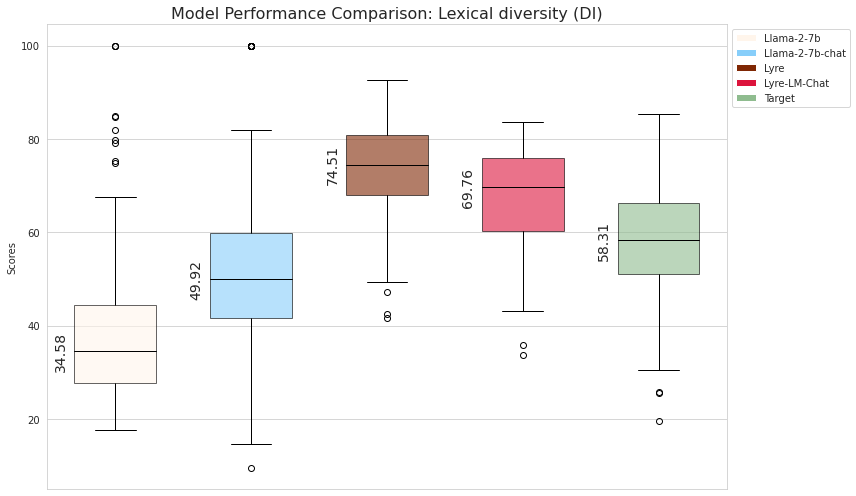

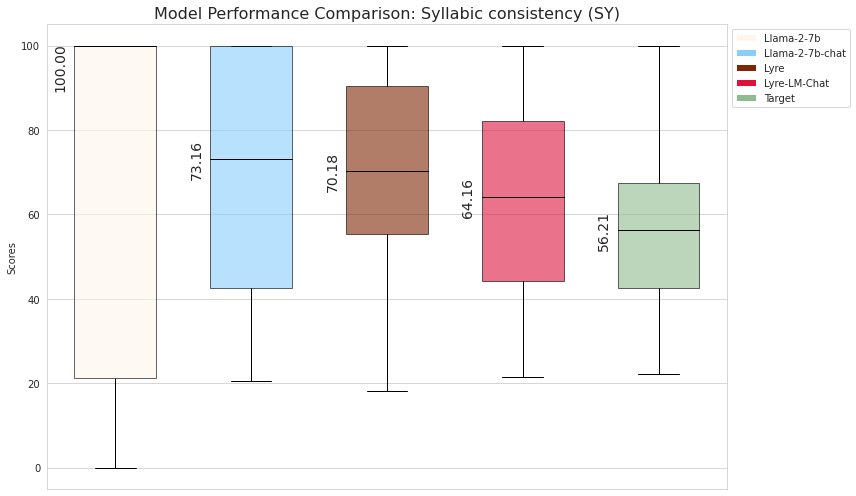

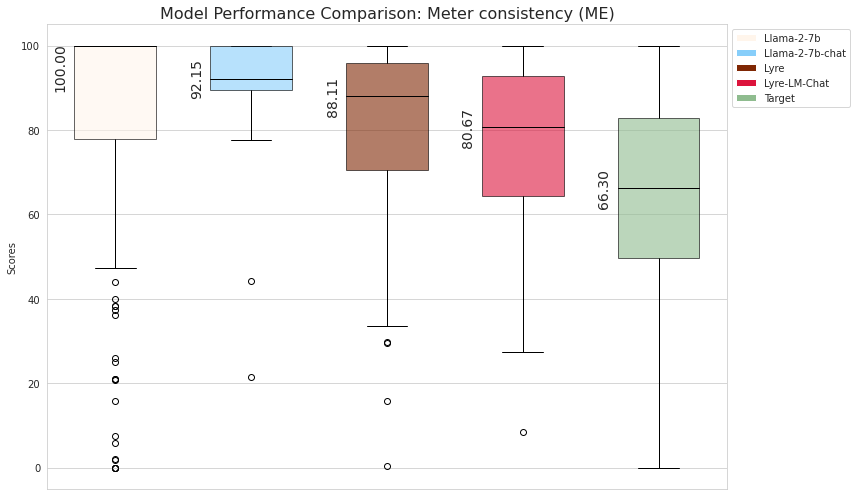

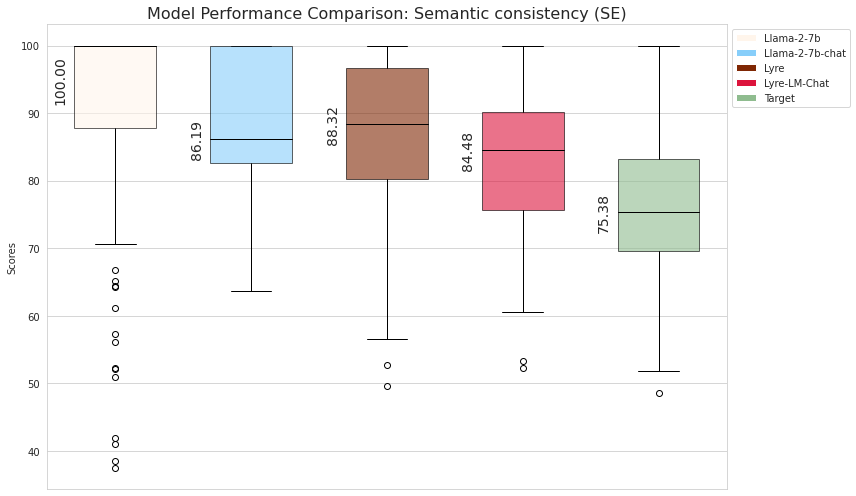

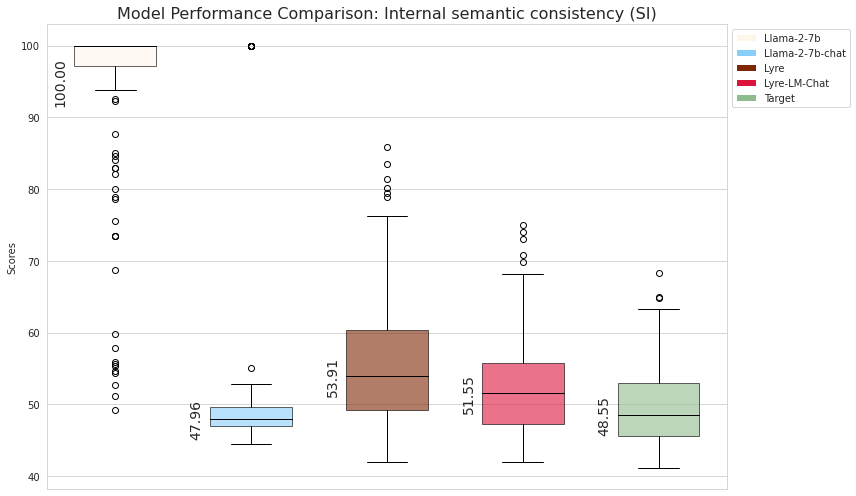

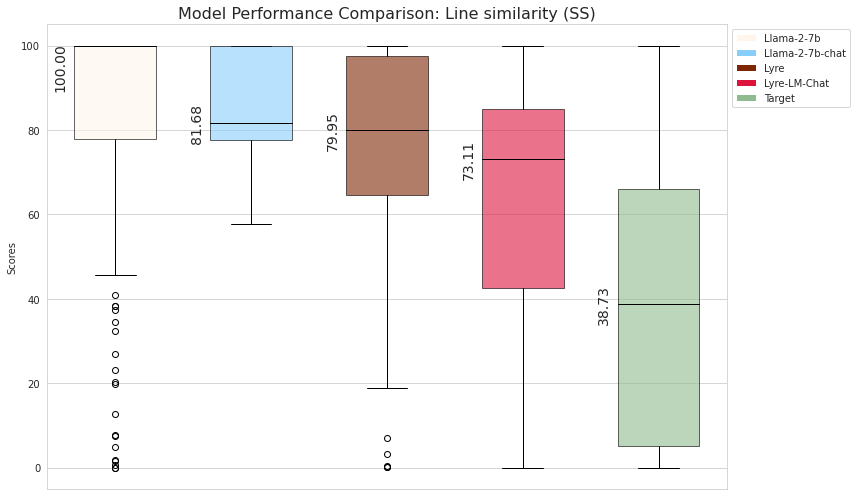

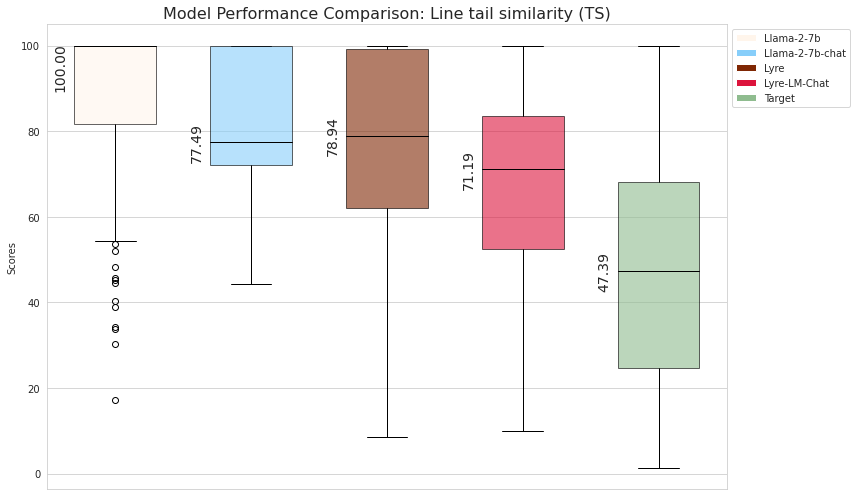

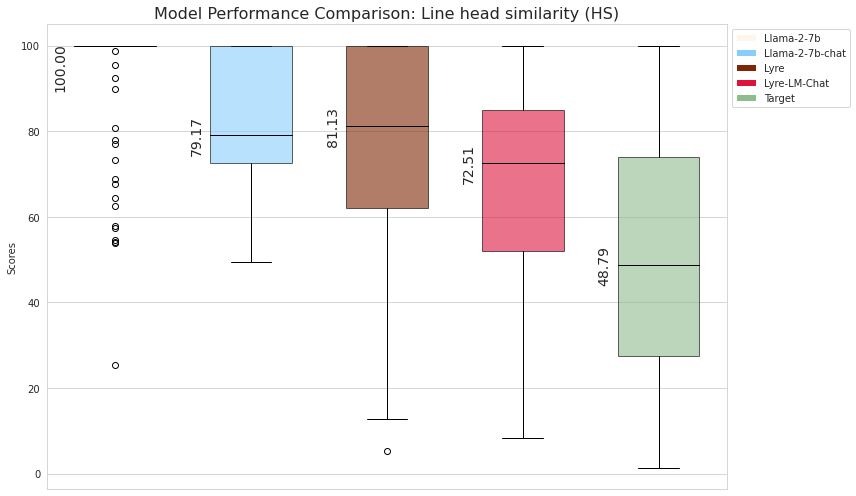

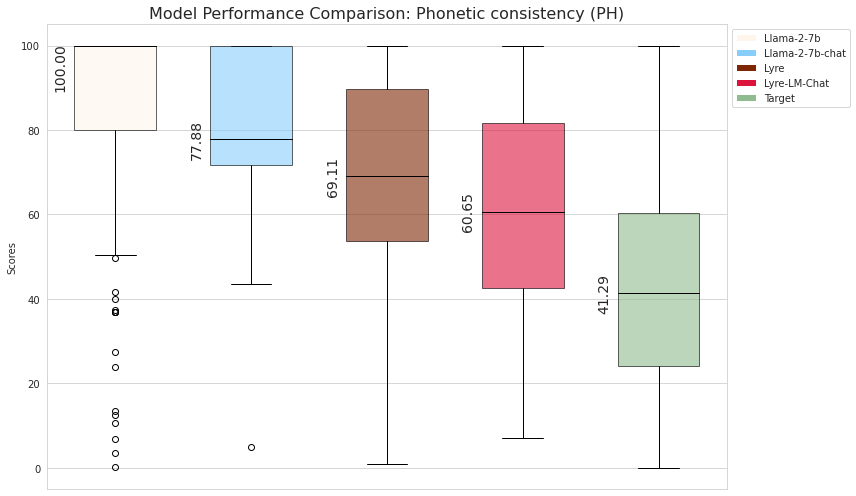

In [50]:
####### Plot measure distributions for CURATED MODELS########
measures_subset = []  # change this to any subset of the measures
if not measures_subset:
    measures_subset = list(all_scores.keys()) 

for i, measure in enumerate(measures_subset):
    plot_utils.measures_boxplot(
        all_scores, 
        [measure],
        measure_tags = [tags[i]],
        models=["llama", "llama_chat", "lyre_150", "lyre_chat_100_temp1", "target"],
        labels=["Llama-2-7b", "Llama-2-7b-chat", "Lyre", "Lyre-LM-Chat", "Target"],
        colors=[colors[0], colors[4], colors[3], colors[9], 'darkseagreen'],
        ylim=None,
        show_outliers=True,
        savef=f"data/metrics/procured_{measure}_dist_plot.png"
    )

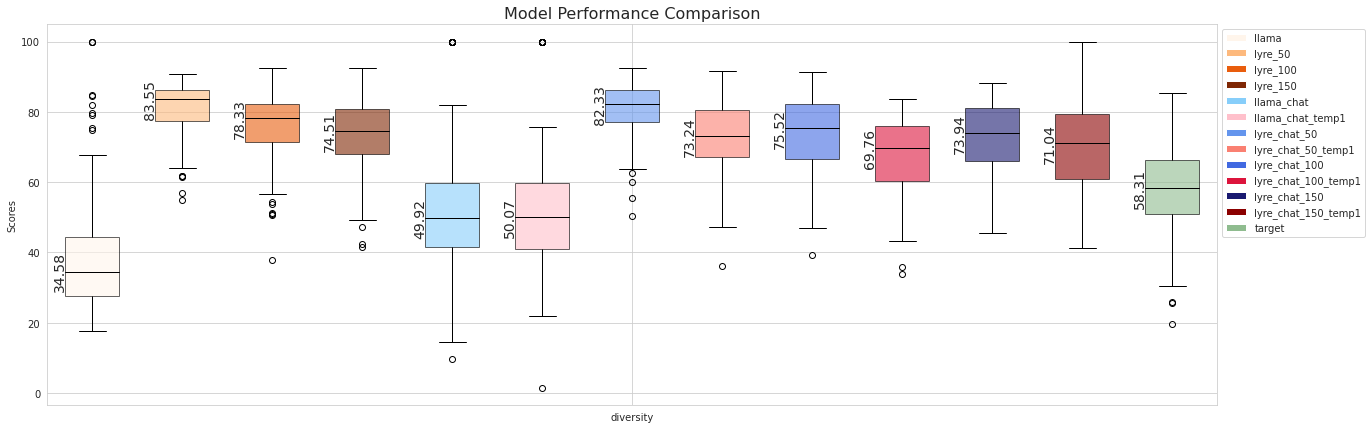

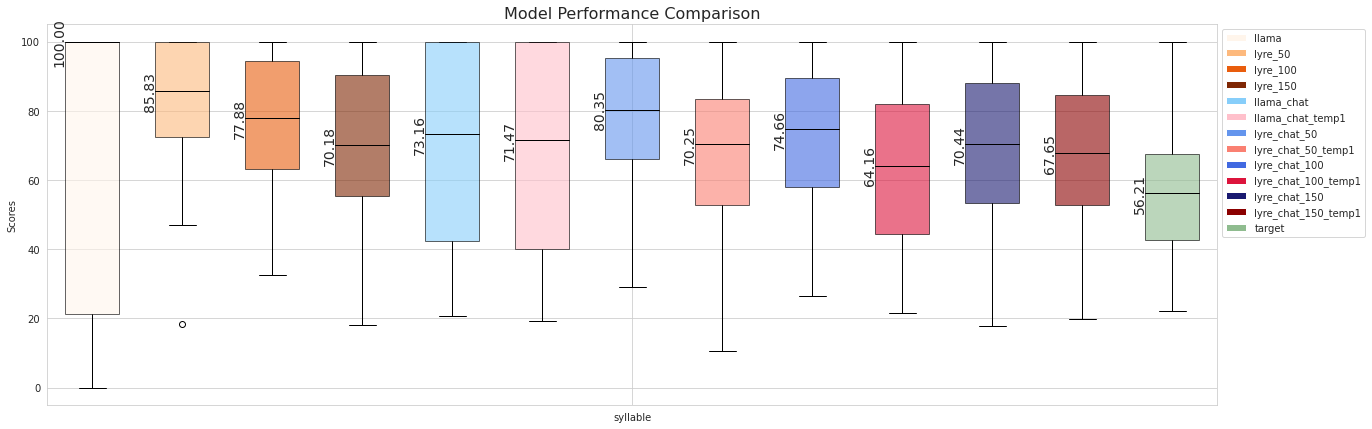

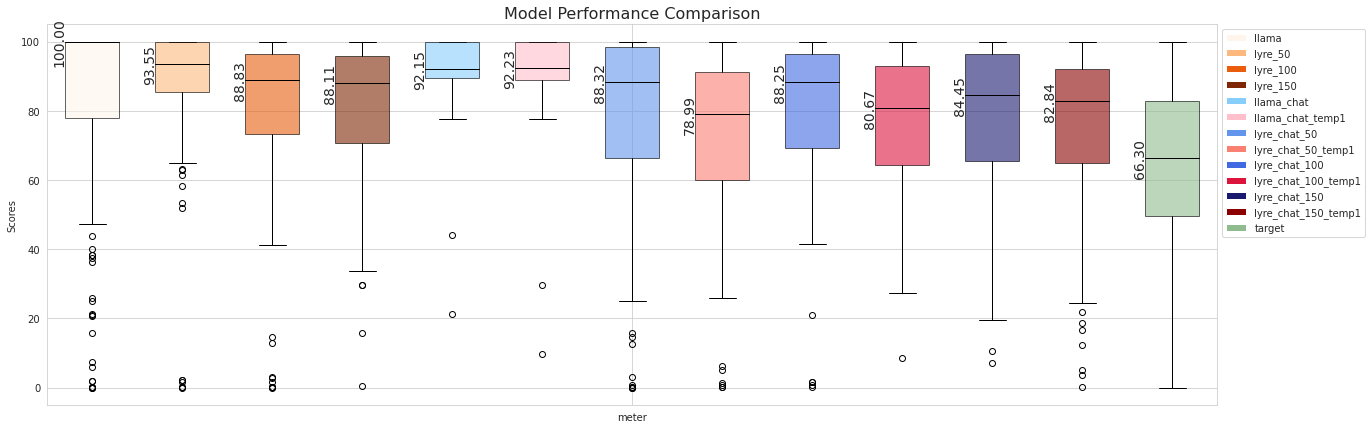

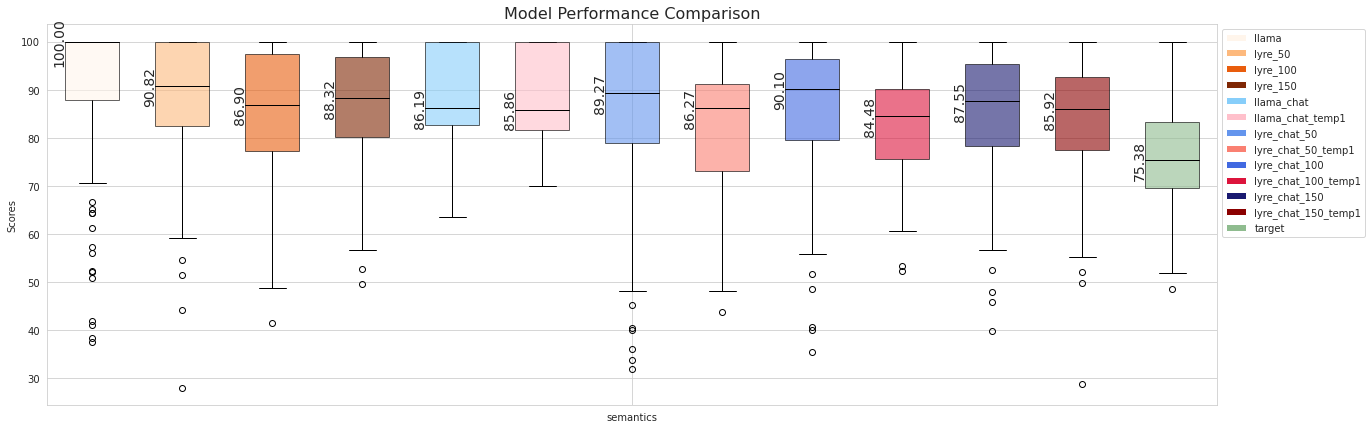

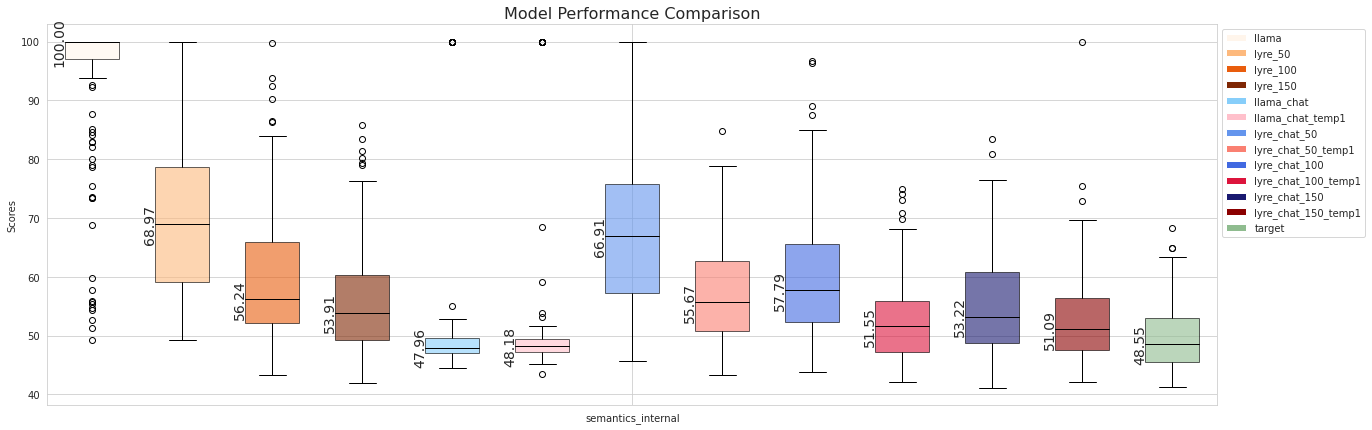

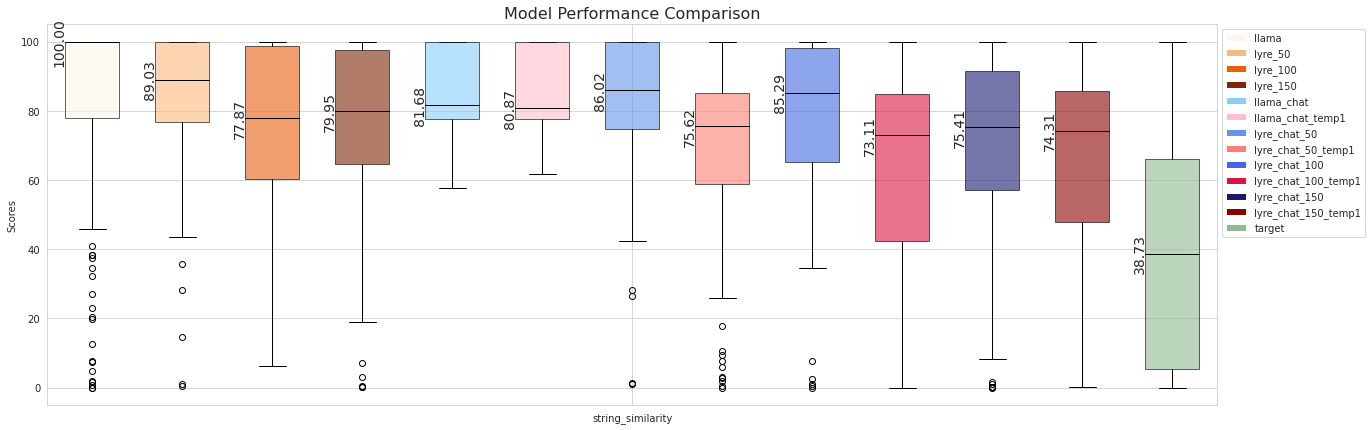

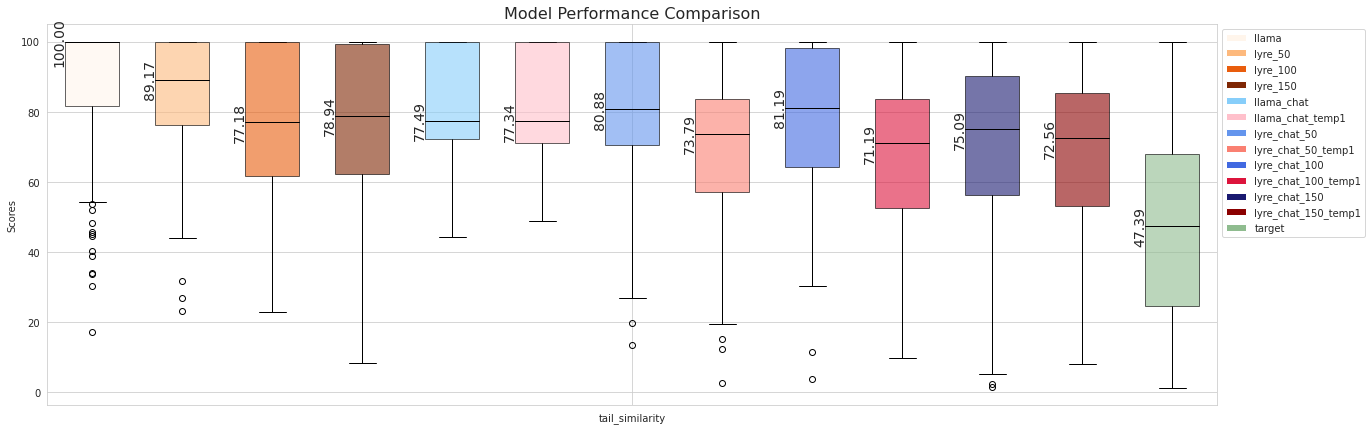

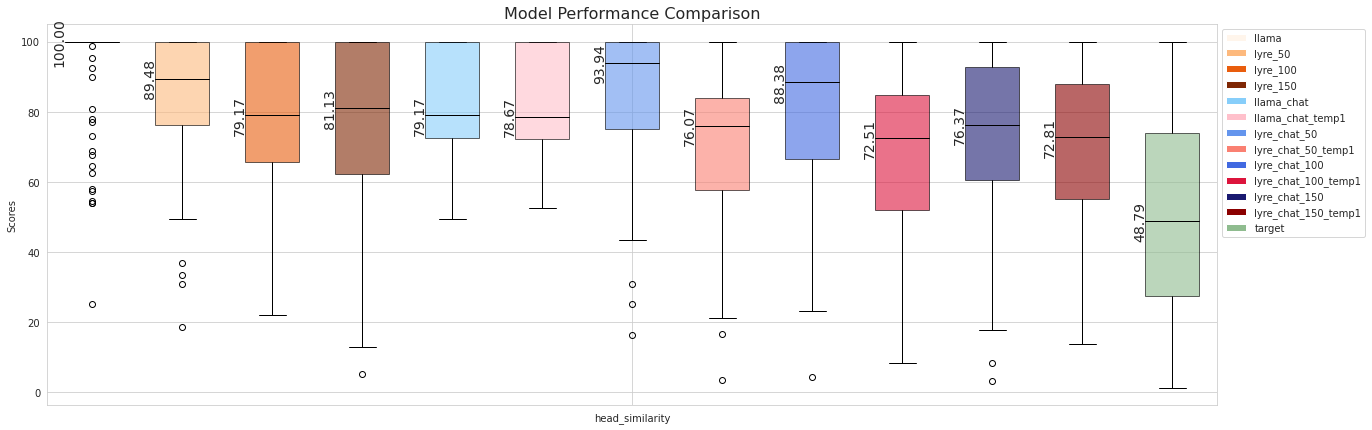

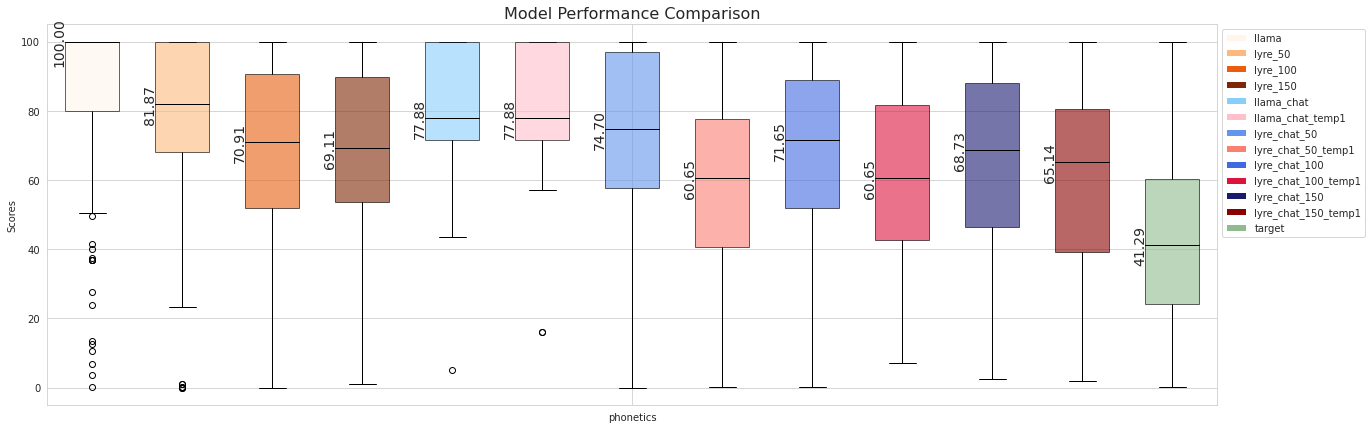

In [27]:
####### Plot measure distributions for ALL MODELS ########
measures_subset = []  # change this to any subset of the measures
if not measures_subset:
    measures_subset = list(all_scores.keys()) 

for measure in measures_subset:
    plot_utils.measures_boxplot(
        all_scores, [measure],
        models=model_names + ["target"],
        labels=model_names + ["target"],
        colors=colors + ['darkseagreen'],
        ylim=None,
        show_outliers=True,
        savef=f"data/metrics/{measure}_dist_plot.png"
    )

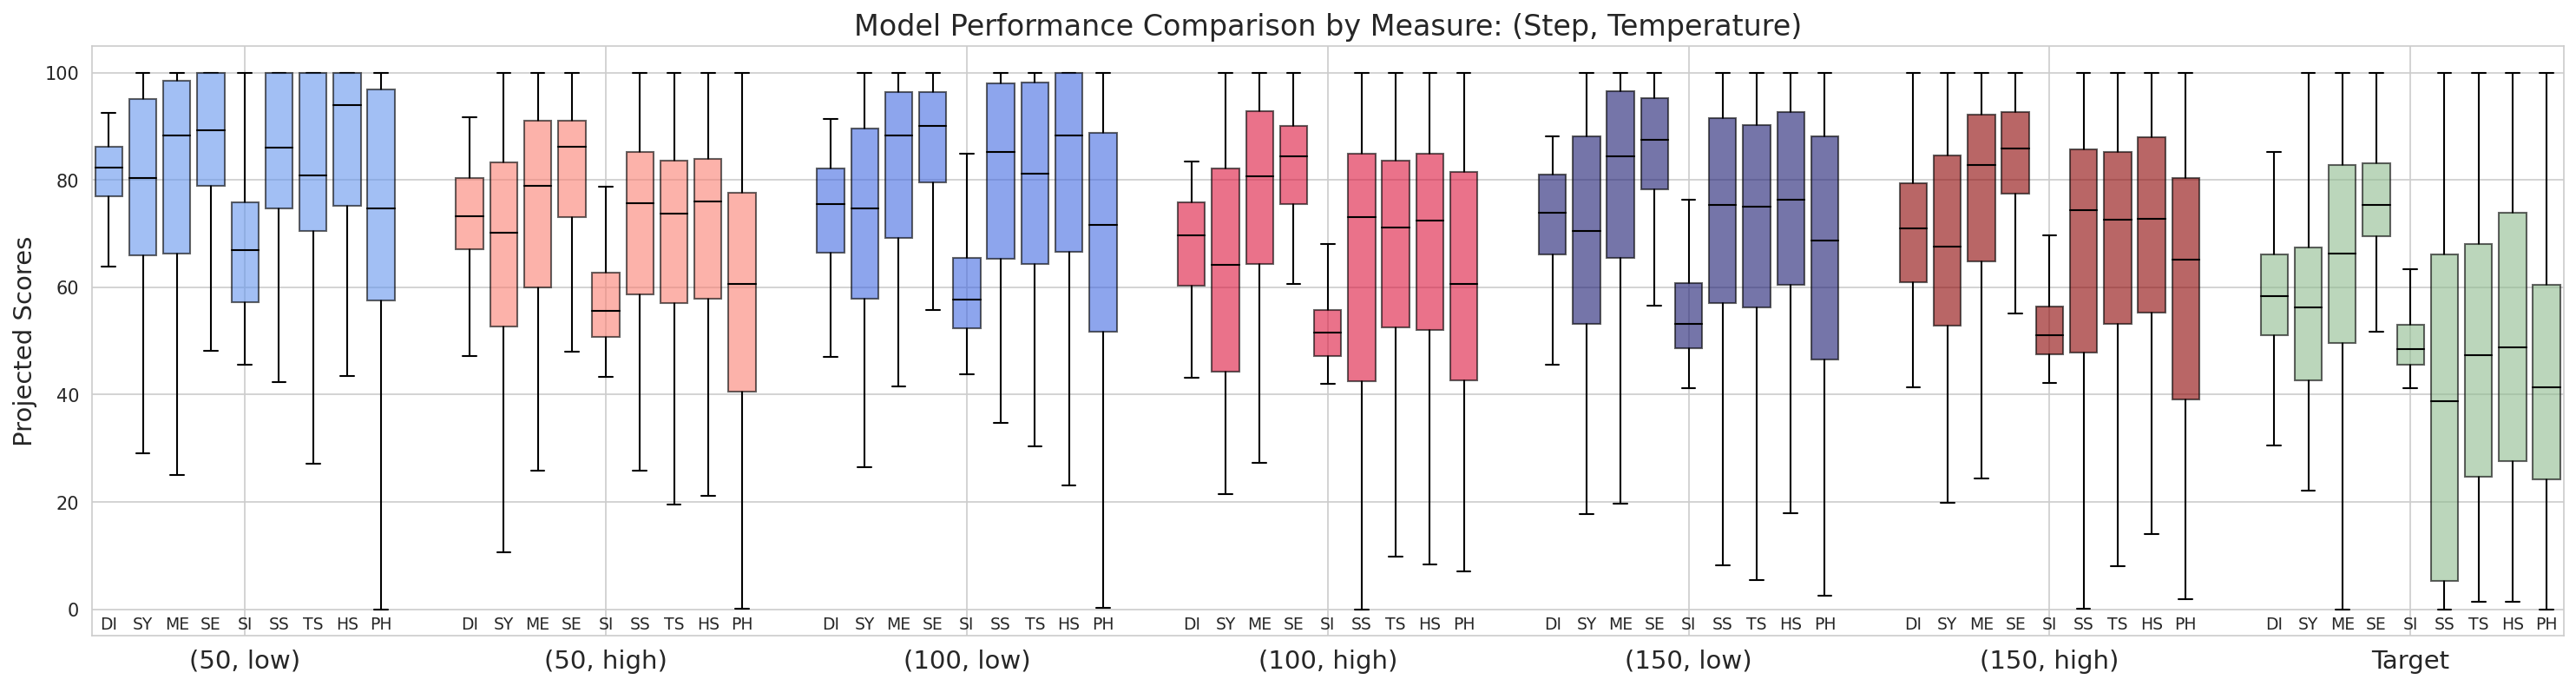

In [57]:
####### Plot measure distributions comparing temperature ########
measures_subset = []  # change this to any subset of the measures
if not measures_subset:
    measures_subset = list(all_scores.keys()) 

plot_utils.measures_boxplot_close(
    all_scores, 
    measures,
    measure_tags=["DI", "SY", "ME", "SE", "SI", "SS", "TS", "HS", "PH"],
    models=model_names[-6:] + ["target"], #model_names + ["target"],
    labels=["(50, low)", "(50, high)", "(100, low)", "(100, high)", "(150, low)", "(150, high)"] + ["Target"], #model_names + ["target"],
    colors=colors[-6:] + ['darkseagreen'], #colors + ['darkseagreen'],
    ylim=None,
    show_outliers=False,
    savef=f"data/metrics/temp_comparison_all_measures_dist_plot.png",
    title = "Model Performance Comparison by Measure: (Step, Temperature)"
)

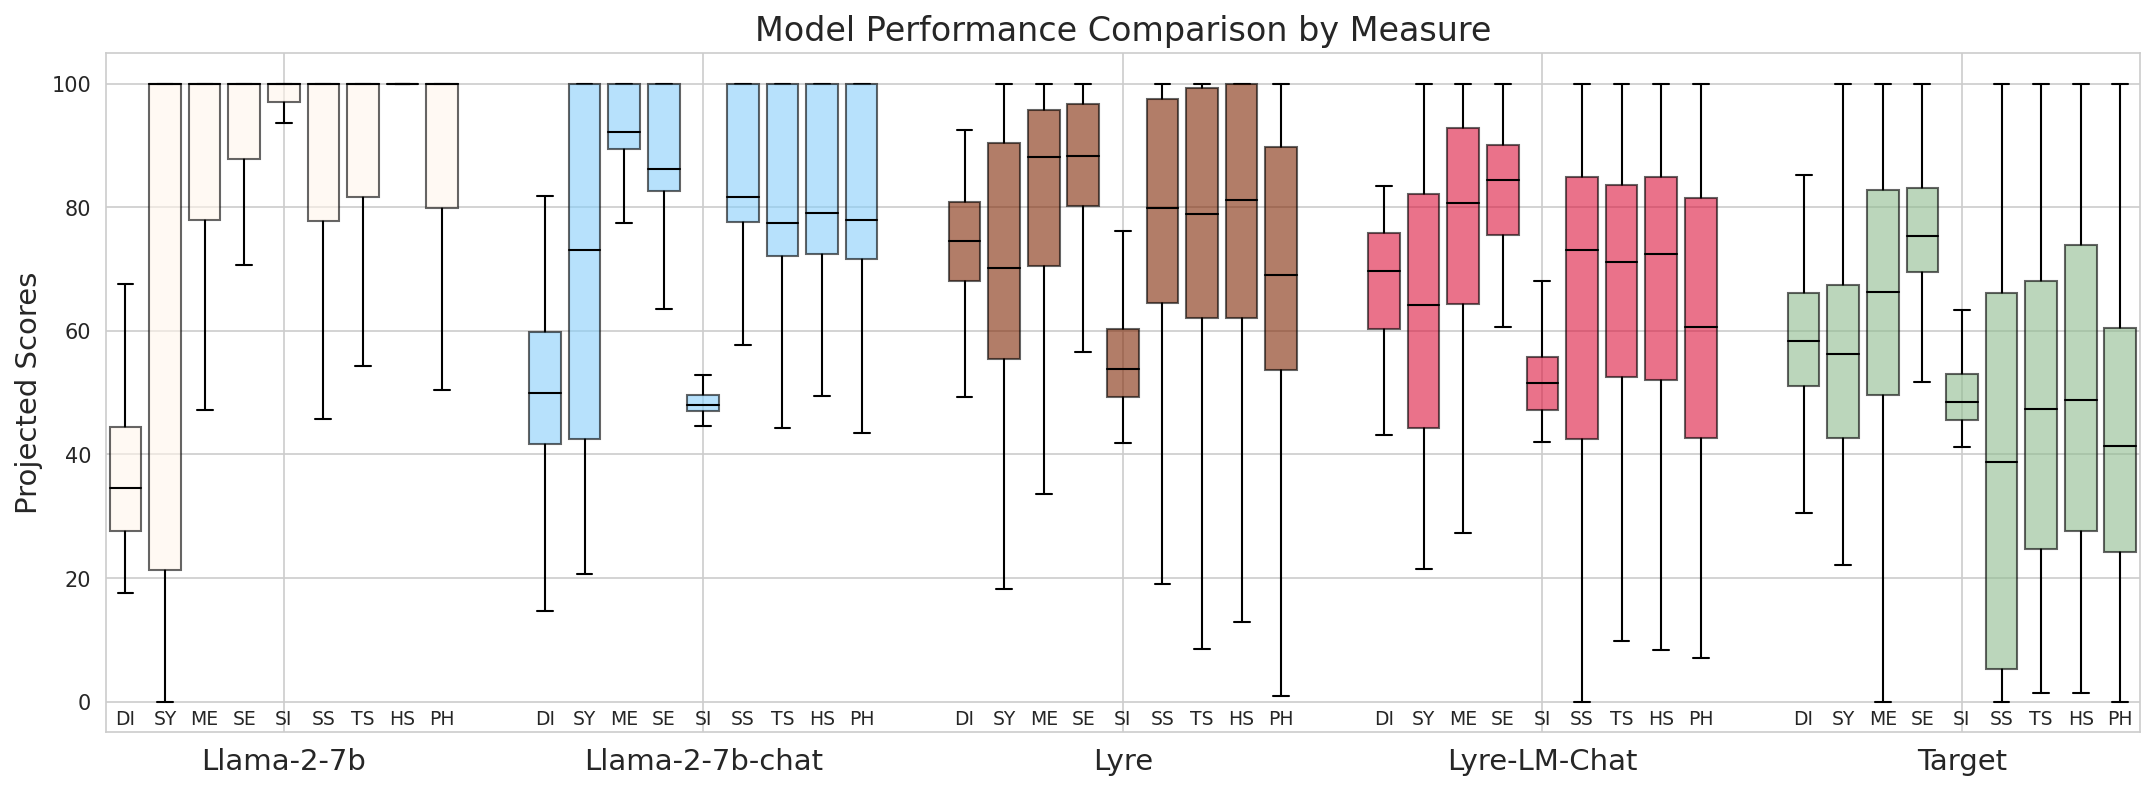

In [56]:
####### Plot measure distributions comparing curated models ########
measures_subset = []  # change this to any subset of the measures
if not measures_subset:
    measures_subset = list(all_scores.keys()) 

plot_utils.measures_boxplot_close(
    all_scores, 
    measures,
    measure_tags=["DI", "SY", "ME", "SE", "SI", "SS", "TS", "HS", "PH"],
    models=["llama", "llama_chat", "lyre_150", "lyre_chat_100_temp1","target"], #model_names + ["target"],
    labels=["Llama-2-7b", "Llama-2-7b-chat", "Lyre", "Lyre-LM-Chat", "Target"], #model_names + ["target"],
    colors=[colors[0], colors[4], colors[3], colors[9], 'darkseagreen'], #colors + ['darkseagreen'],
    ylim=None,
    show_outliers=False,
    savef=f"data/metrics/procured_all_measures_dist_plot.png"
)

Additionally, we also accumulate all the score means and medians into a single [csv file](data/metrics/scores_by_model_and_measure.csv) for each model and measure.

In [77]:
########## Accumulating all the score means and medians ##########
data = []
for m in measures:
    measure_data = {"Measure": m}
    for name in model_names + ["target"]:
        measure_data[name + " median score"] = np.median(all_scores[m][name])
        measure_data[name + " mean score"] = np.mean(all_scores[m][name])
    
    data.append(measure_data)

df = pd.DataFrame(data)
df = df.round(2)
df = df.sort_values(by=['target median score', 'target mean score'], ascending=False)
df.to_csv("data/metrics/scores_by_model_and_measure.csv", index=False)
print(df)

              Measure  llama median score  llama mean score  \
3           semantics              100.00             90.40   
2               meter              100.00             80.99   
0           diversity               34.58             39.84   
1            syllable              100.00             65.40   
7     head_similarity              100.00             95.24   
4  semantics_internal              100.00             93.13   
6     tail_similarity              100.00             87.38   
8           phonetics              100.00             82.37   
5   string_similarity              100.00             81.56   

   lyre_50 median score  lyre_50 mean score  lyre_100 median score  \
3                 90.82               88.35                  86.90   
2                 93.55               85.79                  88.83   
0                 83.55               80.95                  78.33   
1                 85.83               83.02                  77.88   
7                 8